##### redoing the plotting of average genotypes at tag SNPs in the low coverage specimens

In [1]:
import allel
from collections import namedtuple
import datetime
import h5py
import ingenos
import itertools
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import model_selection
%matplotlib inline

##### set base directory

In [2]:
base = "/afs/crc.nd.edu/group/BesanskyNGS/data05/comp_karyo"

##### read in target SNPs

In [3]:
a_top = pd.read_csv(base + "/data/results/2La/comp/predictive_SNPs_train_set_0995_110918.tsv",
               sep = "\t", header=None)

j_top = pd.read_csv(base + "/data/results/2Rj/comp/predictive_SNPs_train_set_08_110918.tsv",
               sep = "\t", header=None)

b_top = pd.read_csv(base + "/data/results/2Rb/comp/predictive_SNPs_train_set_08_110918.tsv",
               sep = "\t", header=None)

u_top = pd.read_csv(base + "/data/results/2Ru/comp/predictive_SNPs_train_set_08_110918.tsv",
               sep = "\t", header=None)

d_top = pd.read_csv(base + "/data/results/2Rd/comp/predictive_SNPs_train_set_08_052619.tsv",
               sep = "\t", header=None)

col_top = pd.read_csv(
    base + "/data/results/2Rc/comp/col_predictive_SNPs_train_set_08_031919.tsv", sep="\t", 
    header=None)

gam_top = pd.read_csv(
    base + "/data/results/2Rc/comp/gam_ss_predictive_SNPs_train_set_08_031919.tsv",
            sep="\t", header=None)

##### read in and prepare low-coverage data from Main et al.

In [4]:
Main_2L = allel.read_vcf(
    '/afs/crc.nd.edu/group/BesanskyNGS/data05/comp_karyo/data/Agam_normfilt_vcfs.vcf.gz',
                   fields = ['*'], region = "2L", types={'calldata/GQ': 'f4'})

Main_2R = allel.read_vcf(
    '/afs/crc.nd.edu/group/BesanskyNGS/data05/comp_karyo/data/Agam_normfilt_vcfs.vcf.gz',
                   fields = ['*'], region = "2R", types={'calldata/GQ': 'f4'})

In [5]:
Main_good_names = ["02SEL85","04SEL02","04SEL14","04SEL021","04SEL18","04SEL84","04SEL91",
                   "010sel134","O10SEL160",
               "2012SEL002","2012SEL003","2012SEL006","2012SEL009","2012sel012",
                   "2012SEL013","2012sel029","2012sel063"]

Main_sample_bool = [sample in Main_good_names for sample in Main_2R["samples"]]

In [6]:
Main_a = [2,2,1,1,2,2,2,2,2,1,2,2,2,2,2,2,2]
Main_b = [2,2,2,1,2,0,0,0,1,2,0,2,2,0,2,1,1]
Main_c = [2,2,0,1,2,0,0,0,1,0,0,2,2,0,2,1,1]
Main_d = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Main_j = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Main_u = [0,0,0,0,0,0,2,2,1,0,0,0,0,1,0,0,0]

In [7]:
Main_md = pd.DataFrame({"sample_ID" : pd.Series(Main_2R["samples"][Main_sample_bool]),
                       "2La" : pd.Series(Main_a),
                       "2Rb" : pd.Series(Main_b),
                       "2Rc" : pd.Series(Main_c),
                       "2Rd" : pd.Series(Main_d),
                       "2Rj" : pd.Series(Main_j),
                       "2Ru" : pd.Series(Main_u)})

Main_md = Main_md[["sample_ID","2La","2Rb","2Rc","2Rd","2Rj","2Ru"]]

In [8]:
Main_2R_gt = allel.GenotypeArray(Main_2R["calldata/GT"]).subset(sel1 = Main_sample_bool)

Main_2R_gq = Main_2R["calldata/GQ"][:,Main_sample_bool]

Main_2R_gt.mask = Main_2R_gq < 20

/afs/crc.nd.edu/user/r/rlove1/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [9]:
Main_2L_gt = allel.GenotypeArray(Main_2L["calldata/GT"]).subset(sel1 = Main_sample_bool)

Main_2L_gq = Main_2L["calldata/GQ"][:,Main_sample_bool]

Main_2L_gt.mask = Main_2L_gq < 20

/afs/crc.nd.edu/user/r/rlove1/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [10]:
Inversion = namedtuple('Inversion',['SNPs','metadata','genotypes','inv_title'])

In [11]:
Main_inv_dict = {"2La" : Inversion(SNPs = a_top.values, metadata = Main_md, 
                                   genotypes = Main_2L_gt, inv_title = "2La"),
                 "2Rj" : Inversion(SNPs = j_top.values, metadata = Main_md, 
                             genotypes = Main_2R_gt, inv_title = "2Rj"),
           "2Rb" : Inversion(SNPs = b_top.values, metadata = Main_md, 
                             genotypes = Main_2R_gt, inv_title = "2Rb"),
        "2Rc_col" : Inversion(SNPs = col_top.values, metadata = Main_md, 
                               genotypes = Main_2R_gt, inv_title = "2Rc"),
           "2Rc_gam" : Inversion(SNPs = gam_top.values, metadata = Main_md, 
                                  genotypes = Main_2R_gt, inv_title = "2Rc"),
           "2Rd" : Inversion(SNPs = d_top.values, metadata = Main_md, 
                             genotypes = Main_2R_gt, inv_title = "2Rd"),
           "2Ru" : Inversion(SNPs = u_top.values, metadata = Main_md, 
                             genotypes = Main_2R_gt, inv_title = "2Ru")}

##### repeat with the Love et al. specimens

##### assemble the metadata

In [12]:
Love_good_names = ['KL0218','KL0220','KL0231','KL0333','KL0341','KL0370','KL0671','KL0899']

Love_good_names

['KL0218',
 'KL0220',
 'KL0231',
 'KL0333',
 'KL0341',
 'KL0370',
 'KL0671',
 'KL0899']

In [13]:
Love_a = [2,2,2,np.nan,np.nan,np.nan,np.nan,np.nan]
Love_b = [2,0,0,0,0,2,2,0]
Love_c = [2,2,2,2,2,2,2,2]
Love_d = [0,0,0,0,0,0,0,0]
Love_j = [2,2,2,2,2,2,2,2]
Love_u = [2,2,2,2,2,2,2,2]

Love_md = pd.DataFrame({"sample_ID" : pd.Series(Love_good_names),
                       "2La" : pd.Series(Love_a),
                       "2Rb" : pd.Series(Love_b),
                       "2Rc" : pd.Series(Love_c),
                       "2Rd" : pd.Series(Love_d),
                       "2Rj" : pd.Series(Love_j),
                       "2Ru" : pd.Series(Love_u)})

Love_md = Love_md[["sample_ID","2La","2Rb","2Rc","2Rd","2Rj","2Ru"]]

##### read in the data

In [14]:
Love_2R = allel.read_vcf(
    '/afs/crc.nd.edu/group/BesanskyNGS/data02/16G_bamako/all.Bamakoset.2.recode.vcf.gz',
                   fields = ['*'], region = "2R", types={'calldata/GQ': 'f4'})

Love_2L = allel.read_vcf(
    '/afs/crc.nd.edu/group/BesanskyNGS/data02/16G_bamako/all.Bamakoset.2.recode.vcf.gz',
                   fields = ['*'], region = "2L", types={'calldata/GQ': 'f4'})

/afs/crc.nd.edu/user/r/rlove1/.local/lib/python3.7/site-packages/allel/io/vcf_read.py:1057: UserWarning: error occurred attempting tabix ([Errno 12] Cannot allocate memory); falling back to scanning to region
  'scanning to region' % e)
/afs/crc.nd.edu/user/r/rlove1/.local/lib/python3.7/site-packages/allel/io/vcf_read.py:1057: UserWarning: error occurred attempting tabix ([Errno 12] Cannot allocate memory); falling back to scanning to region
  'scanning to region' % e)


In [15]:
Love_sample_bool = [sample in Love_good_names for sample in Love_2R["samples"]]

In [16]:
Love_2R_gt = allel.GenotypeArray(Love_2R["calldata/GT"]).subset(sel1 = Love_sample_bool)
Love_2R_gq = Love_2R["calldata/GQ"][:,Love_sample_bool]

Love_2R_gt.mask = Love_2R_gq < 20

/afs/crc.nd.edu/user/r/rlove1/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [17]:
Love_2L_gt = allel.GenotypeArray(Love_2L["calldata/GT"]).subset(sel1 = Love_sample_bool)

Love_2L_gq = Love_2L["calldata/GQ"][:,Love_sample_bool]

Love_2L_gt.mask = Love_2L_gq < 20

/afs/crc.nd.edu/user/r/rlove1/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


##### make the objects to run the process

In [18]:
Love_inv_dict = {"2La" : Inversion(SNPs = a_top.values, metadata = Love_md, 
                                   genotypes = Love_2L_gt, inv_title = "2La"),
           "2Rb" : Inversion(SNPs = b_top.values, metadata = Love_md, 
                             genotypes = Love_2R_gt, inv_title = "2Rb"),
            "2Rc_col" : Inversion(SNPs = col_top.values, metadata = Love_md, 
                                   genotypes = Love_2R_gt, inv_title = "2Rc"),
           "2Rc_gam" : Inversion(SNPs = gam_top.values, metadata = Love_md, 
                                  genotypes = Love_2R_gt, inv_title = "2Rc"),
 "2Rd" : Inversion(SNPs = d_top.values, metadata = Love_md, 
                             genotypes = Love_2R_gt, inv_title = "2Rd"),
           "2Rj" : Inversion(SNPs = j_top.values, metadata = Love_md, 
                             genotypes = Love_2R_gt, inv_title = "2Rj"),
           "2Ru" : Inversion(SNPs = u_top.values, metadata = Love_md, 
                             genotypes = Love_2R_gt, inv_title = "2Ru")}

In [19]:
Love_md

,sample_ID,2La,2Rb,2Rc,2Rd,2Rj,2Ru
0,KL0218,2.0,2,2,0,2,2
1,KL0220,2.0,0,2,0,2,2
2,KL0231,2.0,0,2,0,2,2
3,KL0333,NaN,0,2,0,2,2
4,KL0341,NaN,0,2,0,2,2
5,KL0370,NaN,2,2,0,2,2
6,KL0671,NaN,2,2,0,2,2
7,KL0899,NaN,0,2,0,2,2


In [20]:
Love_average_dict = {inversion : None for inversion in Love_inv_dict.keys()}
Main_average_dict = {inversion : None for inversion in Main_inv_dict.keys()}

In [21]:
for inversion in Love_inv_dict.keys():
    
    ##set up objects
    SNPs = Love_inv_dict[inversion].SNPs
    md = Love_inv_dict[inversion].metadata
    gt = Love_inv_dict[inversion].genotypes
    col_name = Love_inv_dict[inversion].inv_title
    new_col_name = inversion + "_assigned"
    mean_name = inversion + "_means"
    
    if inversion == "2La":
        
        pos = Love_2L["variants/POS"]
        
    else:
        
        pos = Love_2R["variants/POS"]
    
    ##identify sites found in the data
    site_indices = []
    
    for site in SNPs:
    
        where = np.where(pos == site)
        
        if len(where[0]) > 0:
                
            site_indices.append(where[0][0])
            
    print(inversion, "# targets: ", str(len(SNPs)), " # found: ", str(len(site_indices)))
    
    ##identify biallelic sites
    
    bi_bool = gt.subset(sel0 = site_indices).count_alleles().max_allele() <= 1
        
    alts = gt.subset(sel0 = site_indices).subset(sel0 = bi_bool).to_n_alt()
        
    is_called = gt.subset(sel0 = site_indices).subset(sel0 = bi_bool).is_called()
    
    av_gts = np.mean(np.ma.MaskedArray(
            alts, mask = ~is_called), axis=0).data
            
    total_sites = np.sum(is_called, axis=0)
        
    karyos = []
    
    for alt in av_gts:
        
        if alt <= (2/3):
            
            karyos.append(0)
            
        elif alt > (2/3) and alt <= (4/3):
            
            karyos.append(1)
            
        else:
            
            karyos.append(2)
            
    md[new_col_name] = pd.Series(karyos)
    md[mean_name] = pd.Series(av_gts)
    
    mismatches = np.sum(md[new_col_name] != md[col_name])
    
    Love_average_dict[inversion] = (len(site_indices), av_gts)
    
    print(inversion, " # mismatches: ", mismatches,"\n")
    #print(av_gts)
    #print(total_sites,"\n")

2La # targets:  209  # found:  12
2La  # mismatches:  5 

2Rb # targets:  349  # found:  46
2Rb  # mismatches:  0 

2Rc_col # targets:  57  # found:  11
2Rc_col  # mismatches:  8 

2Rc_gam # targets:  49  # found:  3
2Rc_gam  # mismatches:  8 

2Rd # targets:  147  # found:  29
2Rd  # mismatches:  0 

2Rj # targets:  99  # found:  13
2Rj  # mismatches:  0 

2Ru # targets:  177  # found:  19
2Ru  # mismatches:  0 



In [22]:
for inversion in Main_inv_dict.keys():
    
    ##set up objects
    SNPs = Main_inv_dict[inversion].SNPs
    md = Main_inv_dict[inversion].metadata
    gt = Main_inv_dict[inversion].genotypes
    col_name = Main_inv_dict[inversion].inv_title
    new_col_name = inversion + "_assigned"
    mean_name = inversion + "_means"
    
    if inversion == "2La":
        
        pos = Main_2L["variants/POS"]
        
    else:
        
        pos = Main_2R["variants/POS"]
    
    ##identify sites found in the data
    site_indices = []
    
    for site in SNPs:
    
        where = np.where(pos == site)
        
        if len(where[0]) > 0:
                
            site_indices.append(where[0][0])
            
    print(inversion, "# targets: ", str(len(SNPs)), " # found: ", str(len(site_indices)))
    
    ##identify biallelic sites
    
    bi_bool = gt.subset(sel0 = site_indices).count_alleles().max_allele() <= 1
        
    alts = gt.subset(sel0 = site_indices).subset(sel0 = bi_bool).to_n_alt()
        
    is_called = gt.subset(sel0 = site_indices).subset(sel0 = bi_bool).is_called()
    
    av_gts = np.mean(np.ma.MaskedArray(
            alts, mask = ~is_called), axis=0).data
            
    total_sites = np.sum(is_called, axis=0)
        
    karyos = []
    
    for alt in av_gts:
        
        if alt <= (2/3):
            
            karyos.append(0)
            
        elif alt > (2/3) and alt <= (4/3):
            
            karyos.append(1)
            
        else:
            
            karyos.append(2)
            
    md[new_col_name] = pd.Series(karyos)
    md[mean_name] = pd.Series(av_gts)
    
    mismatches = np.sum(md[new_col_name] != md[col_name])
    
    Main_average_dict[inversion] = (len(site_indices), av_gts)
    
    print(inversion, " # mismatches: ", mismatches,"\n")
    #print(av_gts)
    #print(total_sites,"\n")

2La # targets:  209  # found:  200
2La  # mismatches:  2 

2Rj # targets:  99  # found:  96
2Rj  # mismatches:  0 

2Rb # targets:  349  # found:  339
2Rb  # mismatches:  3 

2Rc_col # targets:  57  # found:  56
2Rc_col  # mismatches:  3 

2Rc_gam # targets:  49  # found:  49
2Rc_gam  # mismatches:  12 

2Rd # targets:  147  # found:  96
2Rd  # mismatches:  0 

2Ru # targets:  177  # found:  174
2Ru  # mismatches:  4 



In [23]:
inversion_list = ["2La","2Rj","2Rb","2Rc_col","2Rc_gam","2Rd","2Ru"]
inversion_title_list = ["2La","2Rj","2Rb","2Rc coluzzii","2Rc gambiae","2Rd","2Ru"]

##### drop 2Rd, 2Rj, 2Rc_gam from Main, and 2Rc_col from Love: these are inappropriate cross-taxon applications

##### 2Rc_gam from Main and 2Rc_col from Love are their own figure

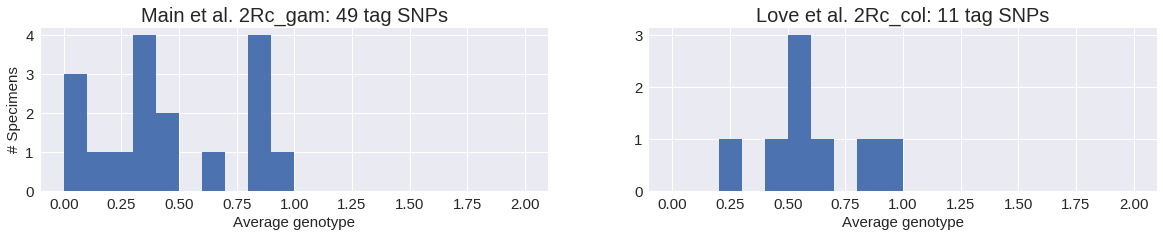

In [24]:
outString2 = ingenos.make_date_stamp(base + "/data/results/comp_aim1/fig_s2")

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize = (20, 3))

inv_1 = Main_average_dict["2Rc_gam"]
inv_2 = Love_average_dict["2Rc_col"]

axes[0].hist(inv_1[1], range=(0,2), bins=20)
axes[0].locator_params(axis="y", integer=True)
axes[0].set_xlabel("Average genotype", fontsize=15)
axes[0].set_ylabel("# Specimens", fontsize=15)
axes[0].tick_params(labelsize=15)
axes[0].set_title("Main et al. 2Rc_gam: {num} tag SNPs".format(num = inv_1[0]),
                 fontsize=20)

axes[1].hist(inv_2[1], range=(0,2), bins=20)
axes[1].locator_params(axis="y", integer=True)
axes[1].set_xlabel("Average genotype", fontsize=15)
axes[1].tick_params(labelsize=15)
axes[1].set_title("Love et al. 2Rc_col: {num} tag SNPs".format(num = inv_2[0]),
                 fontsize=20);

plt.savefig(outString2);

##### run this second, since it overwrites data

In [25]:
Love_average_dict["2Rc"] = Love_average_dict.pop("2Rc_gam")

In [26]:
Main_average_dict["2Rc"] = Main_average_dict.pop("2Rc_col")

In [27]:
inversion_list = ["2La","2Rj","2Rb","2Rc","2Rd","2Ru"]

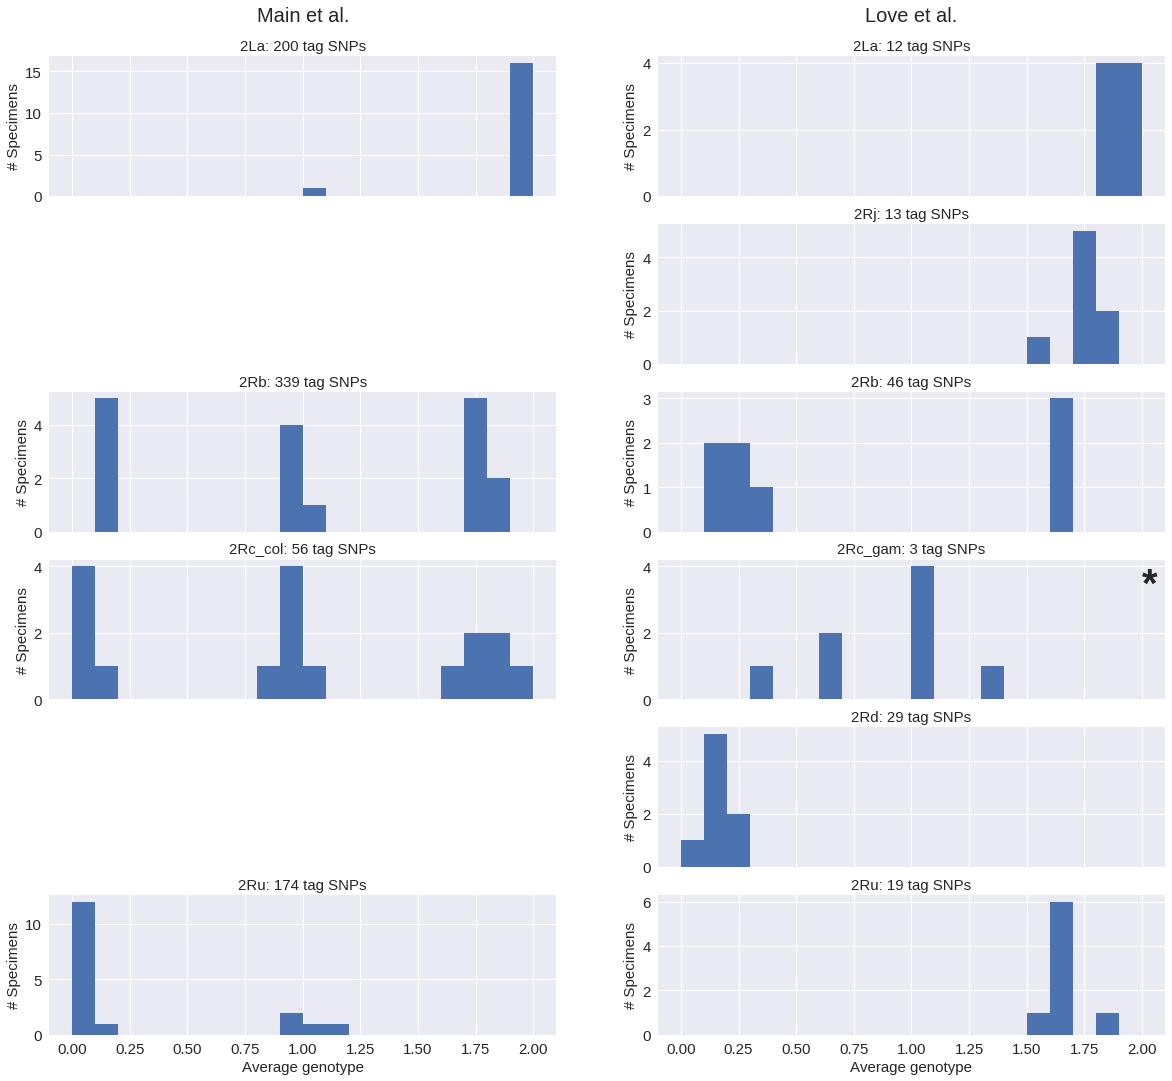

In [28]:
outString5 = ingenos.make_date_stamp(
    base + "/data/results/comp_aim1/fig_5")

fig, axes = plt.subplots(nrows=6, ncols=2, sharex=True, figsize = (20, 18))

for i, ax in enumerate(axes.T.flatten()):
    
    if i <= 5:
        
        av_dict = Main_average_dict
        set_name = "Main"
        inversion = inversion_list[i]
        
    else:
        
        av_dict = Love_average_dict
        set_name = "Love"
        inversion = inversion_list[i-6]
        
    if set_name == "Main" and (inversion == "2Rd" or inversion == "2Rj"):
        
        ax.axis('off')
        
    else:

        num_sites = av_dict[inversion][0]

        alts = av_dict[inversion][1]

        ax.hist(alts, range=(0,2), bins=20)
        ax.locator_params(axis="y", integer=True)

        if i == 5 or i == 11:
            ax.set_xlabel("Average genotype", fontsize=15)

        ax.set_ylabel("# Specimens", fontsize=15)
        ax.tick_params(labelsize=15)
        
        inversion_name = inversion
        
        if inversion == "2Rc":
            
            if set_name == "Main":
                
                inversion_name = "2Rc_col"
                
            else:
                
                inversion_name = "2Rc_gam"
        
        ax.set_title("{inversion}: {num} tag SNPs".format(inversion = inversion_name,
                                                                  num = num_sites),
                     fontsize=15)

        if inversion == "2Rc" and set_name == "Love":

            y_top = ax.get_ylim()[1]

            ax.text(2.0, y_top - 0.2, "*", size=40, weight="bold", va = "top")

for ax, col in zip(axes.T[:,0], ["Main et al.", "Love et al."]):
    ax.annotate(col, (0.5, 1.15), xytext=(0, 10), ha='center', va='bottom',
                size=20, xycoords='axes fraction', textcoords='offset points')
    
plt.savefig(outString5);